<a href="https://colab.research.google.com/github/Satsuki-Kataoka/ai-diary-app/blob/main/my_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import

In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import librosa
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio

import shap

データ取得

In [3]:
import torchaudio
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


分類クラス定義

In [4]:
GENRES = [
    "blues", "classical", "country", "disco", "hiphop",
    "jazz", "metal", "pop", "reggae", "rock"
]

GENRE_TO_LABEL = {g: i for i, g in enumerate(GENRES)}

データ前処理（データ分割・メルスペクトログラム）

In [5]:
DATASET_PATH = Path(path) / "Data" / "genres_original"

SAMPLE_RATE = 22050
NUM_SEGMENTS = 10
SAMPLES_PER_SEGMENT = SAMPLE_RATE * 3

def process_and_save(split_name, wav_list):
    """リストにあるwavファイルを処理して保存する関数"""
    melspecs = []
    labels = []

    for wav_path in tqdm(wav_list, desc=f"Processing {split_name}"):
        genre = wav_path.parent.name
        try:
            signal, sr = librosa.load(wav_path, sr=SAMPLE_RATE)
            for s in range(NUM_SEGMENTS):
                start = SAMPLES_PER_SEGMENT * s
                end = start + SAMPLES_PER_SEGMENT
                segment = signal[start:end]
                if len(segment) < SAMPLES_PER_SEGMENT: continue

                mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
                mel_db = librosa.power_to_db(mel, ref=np.max)
                melspecs.append(mel_db)
                labels.append(GENRE_TO_LABEL[genre])
        except Exception as e:
            print(f"Skip {wav_path}: {e}")

    np.savez(f"{split_name}_data.npz", x=np.array(melspecs), y=np.array(labels))

# --- メイン処理 ---
train_wavs = []
test_wavs = []

random.seed(42) # 結果を固定

for genre in GENRES:
    genre_dir = DATASET_PATH / genre
    wav_files = list(genre_dir.glob("*.wav"))
    random.shuffle(wav_files) # ジャンルごとに曲をシャッフル

    # 8:2で分割（曲単位）
    train_wavs.extend(wav_files[:80])
    test_wavs.extend(wav_files[80:])

print(f"訓練曲数: {len(train_wavs)}, テスト曲数: {len(test_wavs)}")

# それぞれ保存
process_and_save("train", train_wavs)
process_and_save("test", test_wavs)

訓練曲数: 800, テスト曲数: 200


Processing train:  59%|█████▉    | 473/800 [01:10<00:35,  9.32it/s]/tmp/ipython-input-1764407131.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(wav_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing train:  59%|█████▉    | 475/800 [01:10<00:46,  7.01it/s]

Skip /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 


Processing test: 100%|██████████| 200/200 [00:24<00:00,  8.24it/s]


データセット（CNN）

In [6]:
class MusicDataset(Dataset):
    def __init__(self, npz_path):
        with np.load(npz_path, allow_pickle=True) as data:
            self.x = torch.from_numpy(data['x']).float().unsqueeze(1)
            self.y = torch.from_numpy(data['y']).long()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = MusicDataset("train_data.npz")
test_dataset = MusicDataset("test_data.npz")

# DataLoaderの設定
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"学習データ数: {len(train_dataset)}, テストデータ数: {len(test_dataset)}")

学習データ数: 7982, テストデータ数: 1999


CNNモデル

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # 特徴抽出部（畳み込み層）
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 分類部（全結合層）
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128), # ここは入力サイズに合わせて調整が必要な場合があります
            nn.ReLU(),
            nn.Dropout(0.5), # 過学習防止
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# モデルの作成
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)
print(f"使用デバイス: {device}")

使用デバイス: cuda


学習（CNN）

In [8]:
# 1. 損失関数と最適化手法の設定
criterion = nn.CrossEntropyLoss() # 分類問題の定番
optimizer = optim.Adam(model.parameters(), lr=0.001) # 賢く学習率を調整してくれる手法

# 2. 学習ループ
num_epochs = 30

print("学習を開始します...")

for epoch in range(num_epochs):
    model.train() # 学習モード
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 勾配をリセット
        optimizer.zero_grad()

        # 予測 (Forward)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 逆伝播・更新 (Backward & Optimize)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 精度計算
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # --- テストデータでの評価 ---
    model.eval() # 評価モード（ドロップアウトなどを無効化）
    test_correct = 0
    test_total = 0
    with torch.no_grad(): # 勾配計算をオフにしてメモリ節約
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Test Acc: {test_acc:.2f}%")

print("学習完了！")

学習を開始します...
Epoch [1/30] - Loss: 2.1299 - Train Acc: 21.41% - Test Acc: 35.22%
Epoch [2/30] - Loss: 1.8317 - Train Acc: 28.98% - Test Acc: 41.57%
Epoch [3/30] - Loss: 1.7322 - Train Acc: 32.71% - Test Acc: 35.87%
Epoch [4/30] - Loss: 1.7105 - Train Acc: 32.94% - Test Acc: 48.52%
Epoch [5/30] - Loss: 1.6667 - Train Acc: 33.91% - Test Acc: 51.18%
Epoch [6/30] - Loss: 1.6384 - Train Acc: 35.58% - Test Acc: 52.08%
Epoch [7/30] - Loss: 1.6369 - Train Acc: 35.08% - Test Acc: 51.23%
Epoch [8/30] - Loss: 1.5782 - Train Acc: 37.25% - Test Acc: 55.68%
Epoch [9/30] - Loss: 1.5460 - Train Acc: 38.75% - Test Acc: 56.18%
Epoch [10/30] - Loss: 1.5706 - Train Acc: 38.94% - Test Acc: 58.93%
Epoch [11/30] - Loss: 1.5372 - Train Acc: 40.38% - Test Acc: 60.03%
Epoch [12/30] - Loss: 1.5246 - Train Acc: 41.16% - Test Acc: 58.23%
Epoch [13/30] - Loss: 1.5004 - Train Acc: 41.98% - Test Acc: 61.73%
Epoch [14/30] - Loss: 1.4776 - Train Acc: 42.60% - Test Acc: 54.08%
Epoch [15/30] - Loss: 1.4646 - Train Acc: 43.

SHAP（CNN）

CSVデータ読み込み

In [11]:
csv_path = Path(path) / "Data" / "features_3_sec.csv"
df = pd.read_csv(csv_path)

# 特徴量とラベルの整理
numeric_cols = [c for c in df.columns if c not in ['filename', 'length', 'label']]
X = df[numeric_cols].values
y = df['label'].map(GENRE_TO_LABEL).values

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train_wavs と test_wavs のファイル名（拡張子なし）を取得
train_names = [f.stem for f in train_wavs]
test_names = [f.stem for f in test_wavs]

# CSVの'filename'列は 'blues.00000.0.wav' の形式なので、
# 先頭部分が train_names に含まれるかチェックして分割
train_mask = df['filename'].apply(lambda x: ".".join(x.split(".")[:2])).isin(train_names)
test_mask = df['filename'].apply(lambda x: ".".join(x.split(".")[:2])).isin(test_names)

X_train = torch.FloatTensor(X_scaled[train_mask])
y_train = torch.LongTensor(y[train_mask])
X_test = torch.FloatTensor(X_scaled[test_mask])
y_test = torch.LongTensor(y[test_mask])

データセット（MLP）

In [12]:
class MLPDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader_mlp = DataLoader(MLPDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader_mlp = DataLoader(MLPDataset(X_test, y_test), batch_size=32, shuffle=False)

print(f"MLP訓練データ: {len(X_train)}, テストデータ: {len(X_test)}")

MLP訓練データ: 7991, テストデータ: 1999


MLPモデル

In [13]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

model_mlp = SimpleMLP(input_size=len(numeric_cols)).to(device)

学習（MLP）

In [19]:
# 1. 損失関数と最適化手法の設定
criterion = nn.CrossEntropyLoss() # 分類問題の定番
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001) # 賢く学習率を調整してくれる手法

# 2. 学習ループ
num_epochs = 30

print("学習を開始します...")

for epoch in range(num_epochs):
    model.train() # 学習モード
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_mlp:
        inputs, labels = inputs.to(device), labels.to(device)

        # 勾配をリセット
        optimizer.zero_grad()

        # 予測 (Forward)
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)

        # 逆伝播・更新 (Backward & Optimize)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 精度計算
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # --- テストデータでの評価 ---
    model_mlp.eval() # 評価モード（ドロップアウトなどを無効化）
    test_correct = 0
    test_total = 0
    with torch.no_grad(): # 勾配計算をオフにしてメモリ節約
        for inputs, labels in test_loader_mlp:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_mlp(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1} - MLP Test Acc: {100 * test_correct / test_total:.2f}%")

print("学習完了！")

学習を開始します...
Epoch 1 - MLP Test Acc: 68.28%
Epoch 2 - MLP Test Acc: 69.68%
Epoch 3 - MLP Test Acc: 68.93%
Epoch 4 - MLP Test Acc: 69.28%
Epoch 5 - MLP Test Acc: 68.33%
Epoch 6 - MLP Test Acc: 68.98%
Epoch 7 - MLP Test Acc: 69.38%
Epoch 8 - MLP Test Acc: 69.68%
Epoch 9 - MLP Test Acc: 70.09%
Epoch 10 - MLP Test Acc: 70.24%
Epoch 11 - MLP Test Acc: 70.19%
Epoch 12 - MLP Test Acc: 70.24%
Epoch 13 - MLP Test Acc: 70.09%
Epoch 14 - MLP Test Acc: 70.29%
Epoch 15 - MLP Test Acc: 69.98%
Epoch 16 - MLP Test Acc: 70.39%
Epoch 17 - MLP Test Acc: 70.64%
Epoch 18 - MLP Test Acc: 70.64%
Epoch 19 - MLP Test Acc: 70.44%
Epoch 20 - MLP Test Acc: 70.74%
Epoch 21 - MLP Test Acc: 71.04%
Epoch 22 - MLP Test Acc: 70.69%
Epoch 23 - MLP Test Acc: 70.24%
Epoch 24 - MLP Test Acc: 64.38%
Epoch 25 - MLP Test Acc: 68.53%
Epoch 26 - MLP Test Acc: 69.33%
Epoch 27 - MLP Test Acc: 69.28%
Epoch 28 - MLP Test Acc: 69.83%
Epoch 29 - MLP Test Acc: 70.09%
Epoch 30 - MLP Test Acc: 69.88%
学習完了！


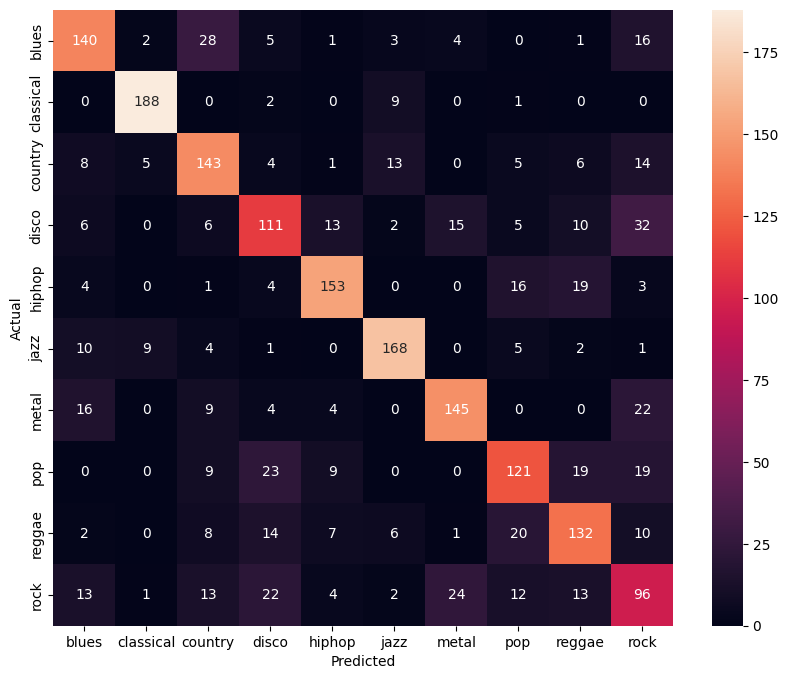

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. テストデータ全体の予測を出す
model_mlp.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_mlp:
        inputs = inputs.to(device)
        outputs = model_mlp(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# 2. 混同行列を作成
cm = confusion_matrix(all_labels, all_preds)

# 3. 可視化
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GENRES, yticklabels=GENRES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SHAP（MLP）

元のSHAP配列の形: (20, 57, 10)
プロットに使うSHAPの形: (20, 57)
入力データの形: (20, 57)


/tmp/ipython-input-1451627486.py:39: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


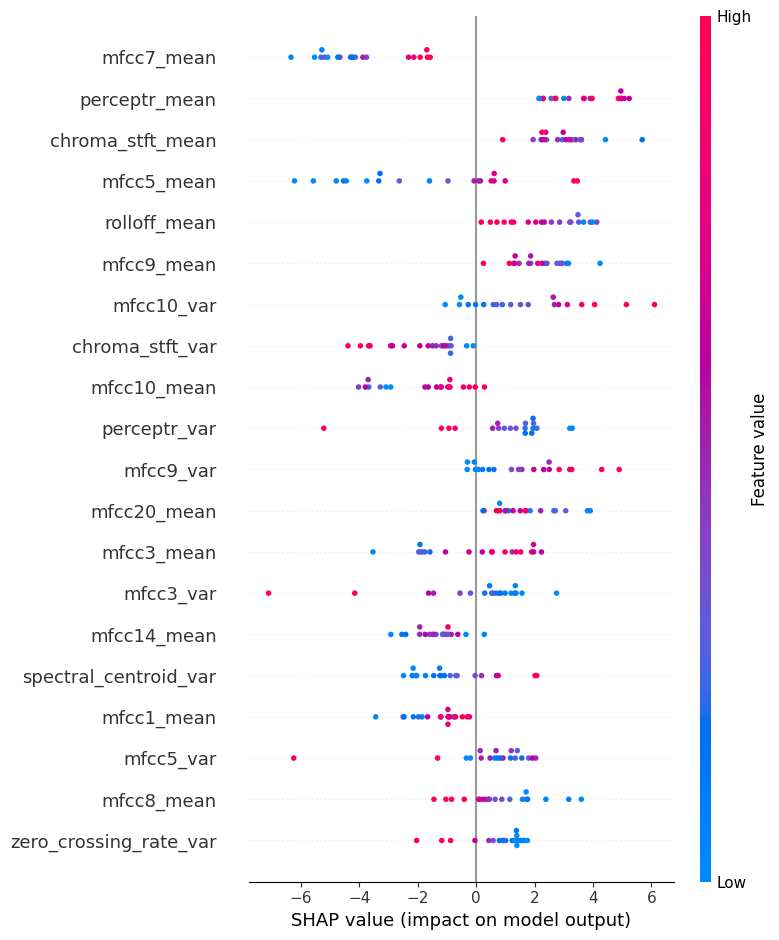

In [21]:
# 1. 背景データの準備
batch = next(iter(train_loader_mlp))
background = batch[0][:100].to(device)
explainer = shap.GradientExplainer(model_mlp, background)

test_batch = next(iter(test_loader_mlp))
test_inputs = test_batch[0][:20].to(device) # 20サンプル

shap_values = explainer.shap_values(test_inputs)

# 2. データの形をチェックして、正しくスライスする
# shap_values がリストの場合、配列に変換
shap_values_arr = np.array(shap_values)

print(f"元のSHAP配列の形: {shap_values_arr.shape}")

# 3. ターゲットとするクラスを抽出
target_class = 2

# リスト形式で返ってきている場合は shap_values[target_class]
# 配列で (クラス, サンプル, 特徴量) の場合は shap_values_arr[target_class]
if isinstance(shap_values, list):
    shap_to_plot = shap_values[target_class]
else:
    # 配列の形に合わせて調整（もし (20, 57, 10) なら [:, :, target_class]）
    if shap_values_arr.ndim == 3:
        # (クラス, サンプル, 特徴量) の場合
        if shap_values_arr.shape[0] == 10:
            shap_to_plot = shap_values_arr[target_class]
        # (サンプル, 特徴量, クラス) の場合
        else:
            shap_to_plot = shap_values_arr[:, :, target_class]

print(f"プロットに使うSHAPの形: {shap_to_plot.shape}") # ここが (20, 57) になればOK
print(f"入力データの形: {test_inputs.cpu().numpy().shape}") # ここも (20, 57)

# 4. 可視化
shap.summary_plot(
    shap_to_plot,
    test_inputs.cpu().numpy(),
    feature_names=numeric_cols
)